## Task 3

In [1]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pandas as pd

from sklearn  import preprocessing


from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.neural_network import MLPClassifier

In [4]:
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')


In [5]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [6]:
sdr_df[sdr_df.split == "TRAIN"].shape

(2000, 5)

In [7]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]


In [8]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

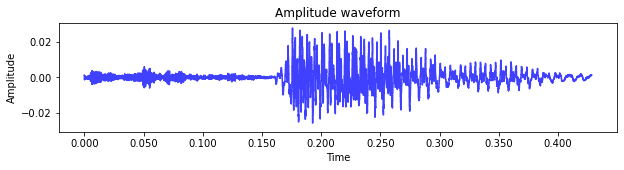

In [9]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [10]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [11]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape
# x.shape

(13, 43)

In [12]:
import os
import time
import random
import tflearn
import librosa
import numpy as np
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [19]:
def downsample_spectrogram(X, N):

    time_splits = np.array_split(X, N, axis=1)
    pooled_splits = [np.mean(split, axis=1) for split in time_splits] 
    v = np.concatenate(pooled_splits)
    return v

In [20]:
def get_downsampled_data(df):
    signals = df.file.values
    labels = df.label.values
    # This value details is given in TASK 1 parameter N <= 25
    N=10   

    signals1 = []
    for file in df.file.values:
        signal1, sr = librosa.load(file)
        signals1.append(signal1)

    return [downsample_spectrogram(extract_melspectrogram(s, sr=8000, num_mels=13), N) for s in signals1], labels


## Data split for George

In [21]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')


speaker = 'george'
train_data = data[data['speaker'] == speaker]
test_data = data[data.speaker != 'george']

downsampled_train, train_labels = get_downsampled_data(train_data)
downsampled_test, test_labels = get_downsampled_data(test_data)

In [14]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')


speaker = 'george'
train_data = data[data['speaker'] == speaker]
test_data = data[data.speaker != 'george']


## Applying BaseLine model on new training data set

In [22]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=0)

clf.fit(downsampled_train, train_labels)


accuracy = clf.score(downsampled_train, train_labels)
print("Accuracy on train set: ", accuracy)

accuracy_test = clf.score(downsampled_test, test_labels)
print("Accuracy on test set: ", accuracy_test)


Accuracy on train set:  0.996
Accuracy on test set:  0.3584


In [23]:
from sklearn.metrics import accuracy_score

test_predictions = clf.predict(downsampled_test)


test_accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on test set: ", test_accuracy)


Accuracy on test set:  0.3584


Confusion matrix on test set: 



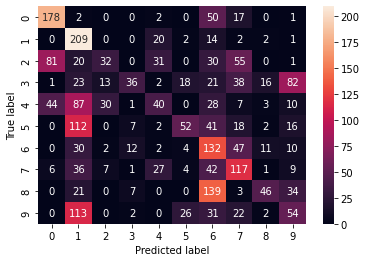

Class 0: TP = 178, TL = 250
Class 1: TP = 209, TL = 250
Class 2: TP = 32, TL = 250
Class 3: TP = 36, TL = 250
Class 4: TP = 40, TL = 250
Class 5: TP = 52, TL = 250
Class 6: TP = 132, TL = 250
Class 7: TP = 117, TL = 250
Class 8: TP = 46, TL = 250
Class 9: TP = 54, TL = 250


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_confusion_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion matrix on test set: \n")
cm_linear_model = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm_linear_model, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Extract true positives (TP) from the diagonal of the confusion matrix
tp = cm_linear_model.diagonal()

# Calculate total labels (TL) for each class by summing over rows of the confusion matrix
tl = cm_linear_model.sum(axis=1)
for i in range(len(tp)):
    print(f"Class {i}: TP = {tp[i]}, TL = {tl[i]}")


In [25]:
from sklearn.metrics import classification_report


test_classification_report = classification_report(test_labels, test_predictions)
print("Classification report on test set: \n", test_classification_report)


Classification report on test set: 
               precision    recall  f1-score   support

           0       0.57      0.71      0.64       250
           1       0.32      0.84      0.46       250
           2       0.38      0.13      0.19       250
           3       0.55      0.14      0.23       250
           4       0.32      0.16      0.21       250
           5       0.49      0.21      0.29       250
           6       0.25      0.53      0.34       250
           7       0.36      0.47      0.41       250
           8       0.55      0.18      0.28       250
           9       0.25      0.22      0.23       250

    accuracy                           0.36      2500
   macro avg       0.40      0.36      0.33      2500
weighted avg       0.40      0.36      0.33      2500



## Training on LSTM

In [26]:
# this section is copy of above get_downsampled_data, only difference is we are not downsampling it in this section for RNN

def get_nn_data(df):
    signals = df.file.values
    labels = df.label.values
    # This value details is given in TASK 1 parameter N <= 25
    # N=10   

    signals1 = []
    for file in df.file.values:
        signal1, sr = librosa.load(file)
        signals1.append(signal1)

    return [extract_melspectrogram(s, sr=8000, num_mels=13) for s in signals1], labels

In [80]:
nn_train, train_labels = get_nn_data(train_data)
print(nn_train[2])

In [81]:
print(nn_train[2])

In [30]:
num_classes = 10
array=train_labels
array=np.array(train_labels)
labels = torch.from_numpy(train_labels)
labels = F.one_hot(labels, num_classes)
labels = labels.type("torch.FloatTensor")


max_len = 130

rnn_train_data = []
for sublist in nn_train:
    x = sublist.shape
#     print("x1", x[1])
#     print("max_len-x1", max_len-x[1])
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_train_data.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))



In [31]:
rnn_train_data = torch.stack(rnn_train_data)

In [82]:
# rnn_train_data = torch.tensor(rnn_train_data)
rnn_train_data.shape

## Data Loader

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNNTrainDataset(Dataset):
    def __init__(self, rnn_train_data, labels):
        self.rnn_train_data = rnn_train_data
        self.labels = labels

    def __len__(self):
        return len(self.rnn_train_data)

    def __getitem__(self, idx):
        return self.rnn_train_data[idx], self.labels[idx]

batch_size = 20

train_dataset = RNNTrainDataset(rnn_train_data, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [83]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

## Hyperparameters

In [35]:
# hp
num_epochs=100
input_size = 13
hidden_size = 128
num_classes = 10
learning_rate = 0.01
n_total_steps = len(rnn_train_data)
num_layers=3






## Lstm model

In [36]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True) #if we want to run LSTM then we need to uncoment this line,and comnt abve line
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2, 20, self.hidden_size, dtype=torch.float32)
        c0 = torch.zeros(2, 20, self.hidden_size, dtype=torch.float32)
        # out : seq_len x hidden_size
        #out, _ = self.rnn(x, h0)
        out, _ = self.lstm(x, (h0, c0))     #if we want to run LSTM then we need to uncoment this line, and coment above line
        out = self.fc(out[:, -1, :])
        out_softmax = F.softmax(out)
        return out, out_softmax

## Training Loop

In [84]:
import matplotlib.pyplot as plt
rnn3 = RNN1(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn3.parameters(), lr=learning_rate)

# initialize an empty list to store the loss at each epoch
loss_history = []
features = []
labels = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for i, (sample, label) in enumerate(train_loader):
        # Forward pass
        last_layer, out = rnn3(sample)
        features.append(last_layer.detach().cpu().numpy())
        labels.append(label.cpu().numpy())
        loss = criterion(out, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples += len(label)

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples
    loss_history.append(train_loss)  # append the loss at this epoch to the list
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
    

# plot the loss history
plt.plot(loss_history)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig('Training_Loss.png')

# Tsne Plot
from sklearn.manifold import TSNE
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# plot the embedded features with different colors for different labels
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
plt.colorbar()
plt.show()

## calculating accuracy on Test set

In [39]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')


speaker = 'george'
train_data = data[data['speaker'] == speaker]
test_data = data[data.speaker != 'george']


In [40]:
test_data_eval, test_labels =get_nn_data(test_data)

In [85]:
test_data_eval

In [86]:
num_classes = 10
array_test=test_labels
array_test=np.array(test_labels)
rnn_test_labels = torch.from_numpy(test_labels)
rnn_test_labels = F.one_hot(rnn_test_labels, num_classes)
rnn_test_labels = rnn_test_labels.type("torch.FloatTensor")
print(len(rnn_test_labels))

max_len = 130

rnn_test_data = []
for sublist in test_data_eval:
    x = sublist.shape
    
   
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_test_data.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))


In [43]:
rnn_test_data = torch.stack(rnn_test_data)

In [87]:
rnn_test_data.shape

In [45]:

batch_size = 20

test_dataset = RNNTrainDataset(rnn_test_data, rnn_test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True )

In [88]:
for batch_idx, (data, target) in enumerate(test_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

In [89]:
rnn_testing = RNN1(input_size, hidden_size, num_classes)
features = []
labels = []

with torch.no_grad():
    total_correct_test = 0
    total_samples_test = 0
    for i, (sample, label) in enumerate(test_loader):
        last_layer, out = rnn3(sample)
        features.append(last_layer.cpu().numpy())
        labels.append(label.cpu().numpy())
        preds_test = torch.argmax(out)
        labels_class_test = torch.argmax(rnn_test_labels[i])
        correct = (preds_test == labels_class_test)
        total_correct_test += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples_test += len(label)
        
    test_acc = total_correct_test / total_samples_test
    print(total_correct_test)
    print(total_samples_test)
    print(f'test accuracy: {test_acc *100:.4f} %')

## Tsne    
# features = np.concatenate(features, axis=0)
# labels = np.concatenate(labels, axis=0)

# tsne = TSNE(n_components=2, random_state=42)
# embedded_features = tsne.fit_transform(features)

# # plot the embedded features with different colors for different labels
# fig, ax = plt.subplots(figsize=(12, 6))

# plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
# plt.title('TSNe for test Classification')
# plt.colorbar()
# plt.show()


In [90]:
from sklearn.metrics import confusion_matrix, classification_report

rnn_testing = RNN1(input_size, hidden_size, num_classes)

with torch.no_grad():
    total_correct_test = 0
    total_samples_test = 0
    all_preds = []
    all_labels = []
    for i, (sample, label) in enumerate(test_loader):
        last_layer, out = rnn3(sample)

        preds_test = torch.argmax(out, dim=1)
        labels_class_test = torch.argmax(label, dim=1)
        
        all_preds.extend(preds_test.cpu().numpy())
        all_labels.extend(labels_class_test.cpu().numpy())
        
        total_correct_test += torch.sum(preds_test == labels_class_test).item()
        total_samples_test += len(label)
        
    test_acc = total_correct_test / total_samples_test
    print(total_correct_test)
    print(total_samples_test)
    print(f'test accuracy: {test_acc *100:.4f} %')
    
#     # Compute confusion matrix
#     cm_test = confusion_matrix(all_labels, all_preds)
#     print('Confusion matrix for test Set:\n')
#     sns.heatmap(cm_test, annot=True, fmt='d')
    
#     # Compute precision, recall, F1-score
#     report = classification_report(all_labels, all_preds)
#     print('Classification report:\n', report)


## Data Augmentation (task 3.2)

In [50]:
import random
import librosa
import numpy as np

def spec_augment(spec, max_time_mask=10, max_freq_mask=5, num_time_mask=2, num_freq_mask=2, max_pitch_shift=2, max_time_warp=5):
    spec = spec.copy()
    
    # time masking
    for i in range(num_time_mask):
        t = np.random.randint(0, max_time_mask)
        t0 = np.random.randint(0, spec.shape[1] - t)
        spec[:, t0:t0 + t] = 0
    
    # frequency masking
    for i in range(num_freq_mask):
        f = np.random.randint(0, max_freq_mask)
        f0 = np.random.randint(0, spec.shape[0] - f)
        spec[f0:f0 + f, :] = 0
    
    # pitch shifting
    pitch_shift = np.random.randint(-max_pitch_shift, max_pitch_shift)
    spec = librosa.effects.pitch_shift(spec, sr=8000, n_steps=pitch_shift, bins_per_octave=12)
    
    # time warping
    time_warp = np.random.randint(0, max_time_warp)
    spec = librosa.effects.time_stretch(spec, np.random.uniform(1 - time_warp/100, 1 + time_warp/100))
    
    return spec


In [91]:
nn_train_augmented = [spec_augment(spec) for spec in nn_train]
print(nn_train_augmented)


In [52]:

num_classes = 10
array=train_labels
array=np.array(train_labels)
labels = torch.from_numpy(train_labels)
labels = F.one_hot(labels, num_classes)
labels = labels.type("torch.FloatTensor")


max_len = 130

rnn_aug_data = []
for sublist in nn_train_augmented:
    x = sublist.shape
#     print("x1", x[1])
#     print("max_len-x1", max_len-x[1])
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_aug_data.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))

    

# rnn_train_data = torch.stack(rnn_train_data)
        


In [53]:
rnn_aug_tensor = torch.stack(rnn_aug_data)


In [92]:
rnn_aug_tensor

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNNTrainDataset(Dataset):
    def __init__(self, rnn_aug_tensor, labels):
        self.rnn_aug_tensor = rnn_aug_tensor
        self.labels = labels

    def __len__(self):
        return len(self.rnn_aug_tensor)

    def __getitem__(self, idx):
        return self.rnn_aug_tensor[idx], self.labels[idx]

batch_size = 20

aug_dataset = RNNTrainDataset(rnn_aug_tensor, labels)
aug_loader = DataLoader(aug_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [93]:
for batch_idx, (data, target) in enumerate(aug_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

In [57]:
# hp
num_epochs=100
input_size = 13
hidden_size = 128
num_classes = 10
learning_rate = 0.01
n_total_steps = len(rnn_aug_tensor)
# num_layers=3





In [58]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True) #if we want to run LSTM then we need to uncoment this line,and comnt abve line
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2, 20, self.hidden_size, dtype=torch.float32)
        c0 = torch.zeros(2, 20, self.hidden_size, dtype=torch.float32)
        # out : seq_len x hidden_size
        #out, _ = self.rnn(x, h0)
        out, _ = self.lstm(x, (h0, c0))     #if we want to run LSTM then we need to uncoment this line, and coment above line
        out = self.fc(out[:, -1, :])
        out_softmax = F.softmax(out)
        return out, out_softmax

In [94]:
import matplotlib.pyplot as plt
rnn3 = RNN1(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn3.parameters(), lr=learning_rate)

# initialize an empty list to store the loss at each epoch
loss_history = []
features = []
labels = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for i, (sample, label) in enumerate(aug_loader):
        # Forward pass
        last_layer, out = rnn3(sample)
        features.append(last_layer.detach().cpu().numpy())
        labels.append(label.cpu().numpy())
        loss = criterion(out, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples += len(label)

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    aug_loss = total_loss / len(aug_loader)
    aug_accuracy = total_correct / total_samples
    loss_history.append(aug_loss)  # append the loss at this epoch to the list
    print(f'Train loss: {aug_loss:.4f}, Train accuracy: {aug_accuracy:.4f}')
    
# plot the loss history
plt.plot(loss_history)
plt.title('Aug Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig('Training_Loss.png')

## Evaluation on test set after data augmentation

In [60]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')


speaker = 'george'
train_data = data[data['speaker'] == speaker]
test_data = data[data.speaker != 'george']


In [95]:
nn_test_augmented = [spec_augment(spec) for spec in test_data_eval]
print(nn_test_augmented)


In [96]:
nn_test_augmented

In [97]:
num_classes = 10
array_test=test_labels
array_test=np.array(test_labels)
rnn_test_labels = torch.from_numpy(test_labels)
rnn_test_labels = F.one_hot(rnn_test_labels, num_classes)
rnn_test_labels = rnn_test_labels.type("torch.FloatTensor")
print(len(rnn_test_labels))

max_len = 130

rnn_test_aug = []
for sublist in nn_test_augmented:
    x = sublist.shape
    
   
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_test_aug.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))


In [64]:
rnn_aug_test_tensor = torch.stack(rnn_test_aug)


In [98]:
print(rnn_aug_test_tensor.shape)

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNNTrainDataset(Dataset):
    def __init__(self, rnn_aug_test_tensor, rnn_test_labels):
        self.rnn_aug_test_tensor = rnn_aug_test_tensor
        self.rnn_test_labels = rnn_test_labels

    def __len__(self):
        return len(self.rnn_aug_test_tensor)

    def __getitem__(self, idx):
        return self.rnn_aug_test_tensor[idx], self.rnn_test_labels[idx]

batch_size = 20

aug_test_dataset = RNNTrainDataset(rnn_aug_test_tensor, rnn_test_labels)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [99]:
for batch_idx, (data, target) in enumerate(aug_test_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

In [100]:
rnn_test_labels

In [101]:
from sklearn.metrics import confusion_matrix, classification_report

rnn = RNN1(input_size, hidden_size, num_classes)

with torch.no_grad():
    total_correct_test = 0
    total_samples_test = 0
    all_preds = []
    all_labels = []
    for i, (sample, label) in enumerate(aug_test_loader):
        last_layer, out = rnn3(sample)

        preds_test = torch.argmax(out, dim=1)
        labels_class_test = torch.argmax(label, dim=1)
        
        all_preds.extend(preds_test.cpu().numpy())
        all_labels.extend(labels_class_test.cpu().numpy())
        
        total_correct_test += torch.sum(preds_test == labels_class_test).item()
        total_samples_test += len(label)
        
    test_acc = total_correct_test / total_samples_test
    print(total_correct_test)
    print(total_samples_test)
    print(f'test accuracy: {test_acc *100:.4f} %')
    
#     # Compute confusion matrix
#     cm_test = confusion_matrix(all_labels, all_preds)
#     print('Confusion matrix for test Set:\n')
#     sns.heatmap(cm_test, annot=True, fmt='d')
    
#     # Compute precision, recall, F1-score
#     report = classification_report(all_labels, all_preds)
#     print('Classification report:\n', report)


## contrastive Learning (task 3.3)

In [70]:
class RNNTrainDataset(Dataset):
    def __init__(self, rnn_aug_test_tensor, rnn_test_labels):
        self.rnn_aug_test_tensor = rnn_aug_test_tensor
        self.rnn_test_labels = rnn_test_labels

    def __len__(self):
        return len(self.rnn_aug_test_tensor)

    def __getitem__(self, idx):
        input1 = self.rnn_aug_test_tensor[idx]
        input2 = torch.zeros_like(input1)
        target = self.rnn_test_labels[idx]
        return input1, input2, target

batch_size = 10

aug_test_dataset = RNNTrainDataset(rnn_aug_test_tensor, rnn_test_labels)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

class ContrastiveLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ContrastiveLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2, 10, self.hidden_size, dtype=torch.float32)
        c0 = torch.zeros(2, 10, self.hidden_size, dtype=torch.float32)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out_softmax = nn.functional.softmax(out)
        return out, out_softmax


class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        # Compute cosine similarity between the two outputs
        cos_sim = nn.functional.cosine_similarity(output1, output2, dim=1)
        # Compute the contrastive loss
        loss = torch.mean((1 - target) * torch.pow(cos_sim, 2) +
                          target * torch.pow(torch.clamp(self.margin - cos_sim, min=0.0), 2))
        return loss

# Initialize your model, loss function, and optimizer
model = ContrastiveLSTM(input_size=13, hidden_size=128, num_classes=10)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [74]:
    num_of_epoch=100
    train_losses = []
    train_accuracies = []
    for epoch in range(num_of_epoch):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (input1, input2, target) in enumerate(aug_test_loader):
            optimizer.zero_grad()
            output1, output1_softmax = model(input1)
            output2, output2_softmax = model(input2)
            loss = criterion(output1, output2, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted1 = torch.max(output1_softmax.data, 1)
            _, predicted2 = torch.max(output2_softmax.data, 1)
            total += target.size(0)
            correct += (predicted1 == predicted2).sum().item()
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(aug_test_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch+1, num_of_epoch, avg_loss, accuracy))
    # Plot the loss per epoch
    plt.plot(range(1, num_of_epoch+1), train_losses)
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## testing accuracy

In [77]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [79]:
import torch.optim as optim

model = ContrastiveLSTM(input_size=13, hidden_size=128, num_classes=10)  # initialize your model
criterion = ContrastiveLoss(margin=1.0, similarity_function=torch.nn.functional.cosine_similarity, temperature=0.5)  # initialize your contrastive loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # initialize your optimizer

# training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data  # get your inputs and labels from the data loader
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # optimize the model parameters
        running_loss += loss.item()  # accumulate loss
        if i % 100 == 99:  # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')
